# Chelsea Jaculina 011274913
# DATA 266 HW 2
# March 23, 2025

# Q1: IMDB Sentiment Classification with LLMs and Prompt Engineering

## Step 0: Install Required Libraries

In [ ]:
!pip install transformers datasets accelerate

# transformers: loads and runs LLMs (BERT, GPT, LLaMA)
# datasets: loads and handles NLP datasets (IMDB)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 1: Load Data & Sample 200 IMDB Reviews

In [1]:
from datasets import load_dataset
import random
import pandas as pd

imdb = load_dataset("imdb")
sample_data = random.sample(list(imdb['test']), 200)
df_sample = pd.DataFrame(sample_data)

print("IMDB dataset loaded successfully!")
print(df_sample.shape)
df_sample.head()


/Users/chelseajaculina/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


IMDB dataset loaded successfully!
(200, 2)


,text,label
0,Billy Wilder created a somewhat conventional b...,1
1,The first bottom movie was an absolute laugh f...,1
2,Great fun for an evening on the sofa. Don't ex...,1
3,I would say this is a background movie. Play i...,0
4,What has hurt this film is everyone and their ...,1


## Step 2: Define Prompting Techniques

In [ ]:
def truncate_text(text, max_chars=350):
    # Truncate at a word boundary to avoid splitting words
    return text[:max_chars].rsplit(" ", 1)[0]

In [ ]:
few_shot_examples = [
    {"text": "This movie was fantastic! The acting was top-notch and the story was gripping.", "label": "Positive"},
    {"text": "I hated every minute of this film. It was boring and predictable.", "label": "Negative"},
    {"text": "Absolutely loved the cinematography and emotional depth. Highly recommend!", "label": "Positive"},
    {"text": "Terrible script and poor character development. Not worth the time.", "label": "Negative"},
    {"text": "One of the best films I’ve seen this year. Beautiful storytelling.", "label": "Positive"},
    {"text": "The plot made no sense and the pacing was awful.", "label": "Negative"},
    {"text": "Brilliant direction and a powerful message. A must-watch.", "label": "Positive"},
    {"text": "The dialogue was cheesy and the acting felt forced.", "label": "Negative"},
    {"text": "Incredible performance by the lead actor. It kept me hooked.", "label": "Positive"},
    {"text": "This movie was a total disaster. Save yourself the trouble.", "label": "Negative"}
]

def zero_shot_prompt(text):
    text = truncate_text(text)
    return f"Classify the sentiment as Positive or Negative:\n\n{text}\n\nSentiment:"

def few_shot_prompt(text):
    text = truncate_text(text)
    prompt = "Classify the sentiment:\n"
    for ex in few_shot_examples:
        prompt += f"Review: {ex['text']}\nSentiment: {ex['label']}\n\n"
    prompt += f"Review: {text}\nSentiment:"
    return prompt

def cot_prompt(text):
    text = truncate_text(text)
    return f"Review: {text}\nExplain the sentiment (positive or negative) and then give your answer."

def self_consistency_prompt(text):
    text = truncate_text(text)
    return cot_prompt(text)

print("Zero Shot defined successfully!")
print("Few Shot defined successfully!")
print("Chain of Thought defined successfully!")
print("Self Consistency defined successfully!")

Zero Shot defined successfully!
Few Shot defined successfully!
Chain of Thought defined successfully!
Self Consistency defined successfully!


## Step 3: Load an LLM

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
          model_name,
          torch_dtype=torch.float16,
          device_map="auto"
    )
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

    return pipe

print("Load an LLM model function defined successfully!")

Load an LLM model function defined successfully!


## Step 4: Predict with Prompt

In [ ]:
import re

# 🧠 Enhanced Chain-of-Thought specific parser
def parse_cot_sentiment(output_text):
    output_text = output_text.lower().strip()
    lines = output_text.splitlines()[-5:]  # Only examine the last 5 lines to reduce noise

    for line in reversed(lines):
        line = line.strip()

        # 🔍 Reasoning-style endings
        if any(phrase in line for phrase in ["therefore", "thus", "as a result", "in conclusion"]):
            if "positive" in line and "negative" not in line:
                return 1
            if "negative" in line and "positive" not in line:
                return 0

        # 🎯 Soft detection without strict formatting
        if "positive" in line and "negative" not in line:
            return 1
        if "negative" in line and "positive" not in line:
            return 0

        # 🏷 Match formatted endings like "Sentiment: Positive"
        if re.search(r"\bsentiment\s*[:\-]?\s*positive\b", line):
            return 1
        if re.search(r"\bsentiment\s*[:\-]?\s*negative\b", line):
            return 0

        # ✅ Match full-line answers
        if re.fullmatch(r"positive", line):
            return 1
        if re.fullmatch(r"negative", line):
            return 0

    return -1  # Could not parse

# 🧩 General sentiment parser with prompt type routing
def get_sentiment_from_output(output_text, prompt_type="default"):
    if prompt_type in ["chain_of_thought", "self_consistency"]:
        return parse_cot_sentiment(output_text)
    else:
        return parse_cot_sentiment(output_text)  # Currently reused for all

# 🔮 Core LLM prediction function
def predict_sentiment(pipe, text, prompt_fn, gen_args=None, prompt_type="default"):
    prompt = prompt_fn(text)
    gen_args = gen_args or {}

    output = pipe(prompt, max_new_tokens=75, **gen_args)[0]["generated_text"]
    return get_sentiment_from_output(output, prompt_type)

print("✅ Enhanced sentiment extraction and prediction functions ready!")

✅ Enhanced sentiment extraction and prediction functions ready!


## Step 5: Self-Consistency Voting

In [ ]:
from collections import Counter

def predict_with_self_consistency(pipe, text, prompt_fn, samples=3, gen_args=None, prompt_type="self_consistency"):
    prompt = prompt_fn(text)
    prompts = [prompt] * samples
    gen_args = gen_args or {}

    outputs = pipe(prompts, max_new_tokens=50, **gen_args)

    preds = []
    for out in outputs:
        generated = out[0]["generated_text"] if isinstance(out, list) else out["generated_text"]
        pred = get_sentiment_from_output(generated, prompt_type)
        if pred != -1:
            preds.append(pred)

    return Counter(preds).most_common(1)[0][0] if preds else -1

print("Efficient self-consistency prediction function successfully!")

Efficient self-consistency prediction function successfully!


## Step 6: Evaluate Results

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(pipe, prompt_fn, use_self_consistency=False, gen_args=None, prompt_type="default"):
    y_true = []
    y_pred = []
    skipped = 0
    total = len(df_sample)

    for _, row in df_sample.iterrows():
        text = row['text']
        true = row['label']

        pred = (
            predict_with_self_consistency(pipe, text, prompt_fn, gen_args=gen_args, prompt_type=prompt_type)
            if use_self_consistency else
            predict_sentiment(pipe, text, prompt_fn, gen_args=gen_args, prompt_type=prompt_type)
        )

        if pred == -1:
            skipped += 1
            continue

        y_true.append(true)
        y_pred.append(pred)

    print(f"Evaluation complete. Predictions made: {len(y_pred)} / {total}")
    print(f"Skipped predictions: {skipped}")

    if len(y_pred) == 0:
        print("No valid predictions. Returning 0.0 for all metrics.")
        return {
            "accuracy": 0.0,
            "precision": 0.0,
            "recall": 0.0,
            "f1_score": 0.0
        }

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1_score": f1_score(y_true, y_pred, zero_division=0)
    }

print("Evaluation metrics calculated successfully!")

Evaluation metrics calculated successfully!


## Login to Hugging Face

In [ ]:


print("✅ Login to Hugging Face successful!")

✅ Login to Hugging Face successful!


## Step 7: Run Models and Compare

### Model 1: Gemma-2B

In [ ]:
# 📦 Define just one model
model_name = "Gemma-2B"
model_id = "google/gemma-2b-it"

# ✅ Prompting styles
prompt_styles = {
    "zero_shot": zero_shot_prompt,
    "few_shot": few_shot_prompt,
    "chain_of_thought": cot_prompt,
    "self_consistency": self_consistency_prompt
}

# ✅ Load model
pipe = load_model(model_id)

# ✅ Collect results
import time
from datetime import datetime
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []

for prompt_name, prompt_fn in prompt_styles.items():
    print(f"Evaluating {model_name} with {prompt_name}")

    start = time.time()

    gen_args = {
        "do_sample": True,
        "temperature": 0.7,
        "top_p": 0.95
    } if prompt_name == "self_consistency" else {"do_sample": False}

    metrics = evaluate(
        pipe,
        prompt_fn,
        use_self_consistency=(prompt_name == "self_consistency"),
        gen_args=gen_args,
        prompt_type=prompt_name
    )

    duration = round(time.time() - start, 2)

    results.append({
        "model": model_name,
        "prompting": prompt_name,
        "time_sec": duration,
        **metrics
    })

    print(
        f"Accuracy: {metrics['accuracy']:.2f} | "
        f"Precision: {metrics['precision']:.2f} | "
        f"Recall: {metrics['recall']:.2f} | "
        f"F1 Score: {metrics['f1_score']:.2f}\n"
         f"✅ Done: {model_name} + {prompt_name} in {duration} sec\n"

    )

# ✅ Convert to DataFrame
df_model = pd.DataFrame(results)

# ✅ Save to CSV
filename = f"{model_name.replace('-', '_').lower()}_results.csv"
df_model.to_csv(filename, index=False)

print(f"\n📁 Results saved to: {filename}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Evaluating Gemma-2B with zero_shot
Evaluation complete. Predictions made: 200 / 200
Skipped predictions: 0
Accuracy: 0.77 | Precision: 0.88 | Recall: 0.66 | F1 Score: 0.75
✅ Done: Gemma-2B + zero_shot in 37.43 sec

Evaluating Gemma-2B with few_shot
Evaluation complete. Predictions made: 200 / 200
Skipped predictions: 0
Accuracy: 0.81 | Precision: 0.84 | Recall: 0.81 | F1 Score: 0.82
✅ Done: Gemma-2B + few_shot in 13.35 sec

Evaluating Gemma-2B with chain_of_thought
Evaluation complete. Predictions made: 200 / 200
Skipped predictions: 0
Accuracy: 0.84 | Precision: 0.90 | Recall: 0.81 | F1 Score: 0.85
✅ Done: Gemma-2B + chain_of_thought in 240.43 sec

Evaluating Gemma-2B with self_consistency
Evaluation complete. Predictions made: 199 / 200
Skipped predictions: 1
Accuracy: 0.82 | Precision: 0.89 | Recall: 0.77 | F1 Score: 0.83
✅ Done: Gemma-2B + self_consistency in 651.18 sec


📁 Results saved to: gemma_2b_results.csv


### Model #2: DeepSeek

In [ ]:
# 📦 Define just one model
model_name = "DeepSeek"
model_id = "deepseek-ai/deepseek-llm-7b-chat"

# ✅ Prompting styles
prompt_styles = {
    "zero_shot": zero_shot_prompt,
    "few_shot": few_shot_prompt,
    "chain_of_thought": cot_prompt,
    "self_consistency": self_consistency_prompt
}

# ✅ Load model
pipe = load_model(model_id)

# ✅ Collect results
import time
from datetime import datetime
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []

for prompt_name, prompt_fn in prompt_styles.items():
    print(f"Evaluating {model_name} with {prompt_name}")

    start = time.time()

    gen_args = {
        "do_sample": True,
        "temperature": 0.7,
        "top_p": 0.95
    } if prompt_name == "self_consistency" else {"do_sample": False}

    metrics = evaluate(
        pipe,
        prompt_fn,
        use_self_consistency=(prompt_name == "self_consistency"),
        gen_args=gen_args,
        prompt_type=prompt_name
    )

    duration = round(time.time() - start, 2)

    results.append({
        "model": model_name,
        "prompting": prompt_name,
        "time_sec": duration,
        **metrics
    })

    print(
        f"Accuracy: {metrics['accuracy']:.2f} | "
        f"Precision: {metrics['precision']:.2f} | "
        f"Recall: {metrics['recall']:.2f} | "
        f"F1 Score: {metrics['f1_score']:.2f}\n"
         f"✅ Done: {model_name} + {prompt_name} in {duration} sec\n"

    )

# ✅ Convert to DataFrame
df_model = pd.DataFrame(results)

# ✅ Save to CSV
filename = f"{model_name.replace('-', '_').lower()}_results.csv"
df_model.to_csv(filename, index=False)

print(f"\n📁 Results saved to: {filename}")

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Evaluating DeepSeek with zero_shot
Evaluation complete. Predictions made: 195 / 200
Skipped predictions: 5
Accuracy: 0.83 | Precision: 0.95 | Recall: 0.71 | F1 Score: 0.82
✅ Done: DeepSeek + zero_shot in 23.86 sec

Evaluating DeepSeek with few_shot


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Evaluation complete. Predictions made: 200 / 200
Skipped predictions: 0
Accuracy: 0.59 | Precision: 0.76 | Recall: 0.36 | F1 Score: 0.49
✅ Done: DeepSeek + few_shot in 161.56 sec

Evaluating DeepSeek with chain_of_thought


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Evaluation complete. Predictions made: 177 / 200
Skipped predictions: 23
Accuracy: 0.88 | Precision: 0.96 | Recall: 0.81 | F1 Score: 0.88
✅ Done: DeepSeek + chain_of_thought in 363.2 sec

Evaluating DeepSeek with self_consistency
Evaluation complete. Predictions made: 187 / 200
Skipped predictions: 13
Accuracy: 0.84 | Precision: 0.94 | Recall: 0.75 | F1 Score: 0.84
✅ Done: DeepSeek + self_consistency in 782.36 sec


📁 Results saved to: deepseek_results.csv


### Model #3: Phi-2

In [ ]:
# 📦 Define just one model
model_name = "Phi-2"
model_id = "microsoft/phi-2"

# ✅ Prompting styles
prompt_styles = {
    "zero_shot": zero_shot_prompt,
    "few_shot": few_shot_prompt,
    "chain_of_thought": cot_prompt,
    "self_consistency": self_consistency_prompt
}

# ✅ Suppress pad_token warnings
import warnings
from transformers import logging as hf_logging
warnings.filterwarnings("ignore")
hf_logging.set_verbosity_error()

# ✅ Load model with pad_token_id set
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

def load_model(model_id):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto"
    )

    return pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        pad_token_id=tokenizer.eos_token_id  # ✅ suppress warning
    )

pipe = load_model(model_id)

# ✅ Collect results
import time
from datetime import datetime
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []

for prompt_name, prompt_fn in prompt_styles.items():
    print(f"\n🔍 Evaluating {model_name} with {prompt_name}")
    start = time.time()

    gen_args = {
        "do_sample": True,
        "temperature": 0.7,
        "top_p": 0.95
    } if prompt_name == "self_consistency" else {"do_sample": False}

    metrics = evaluate(
        pipe,
        prompt_fn,
        use_self_consistency=(prompt_name == "self_consistency"),
        gen_args=gen_args,
        prompt_type=prompt_name
    )

    duration = round(time.time() - start, 2)

    results.append({
        "model": model_name,
        "prompting": prompt_name,
        "time_sec": duration,
        **metrics
    })

    print(
        f"✅ Done: {model_name} + {prompt_name} in {duration} sec\n"
        f"Accuracy: {metrics['accuracy']:.2f} | "
        f"Precision: {metrics['precision']:.2f} | "
        f"Recall: {metrics['recall']:.2f} | "
        f"F1 Score: {metrics['f1_score']:.2f}"
    )

# ✅ Save to CSV
df_model = pd.DataFrame(results)
filename = f"{model_name.replace('-', '_').lower()}_results.csv"
df_model.to_csv(filename, index=False)

print(f"\n📁 Results saved to: {filename}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


🔍 Evaluating Phi-2 with zero_shot
Evaluation complete. Predictions made: 194 / 200
Skipped predictions: 6
✅ Done: Phi-2 + zero_shot in 65.47 sec
Accuracy: 0.81 | Precision: 0.82 | Recall: 0.78 | F1 Score: 0.80

🔍 Evaluating Phi-2 with few_shot
Evaluation complete. Predictions made: 194 / 200
Skipped predictions: 6
✅ Done: Phi-2 + few_shot in 404.81 sec
Accuracy: 0.63 | Precision: 0.63 | Recall: 0.65 | F1 Score: 0.64

🔍 Evaluating Phi-2 with chain_of_thought
Evaluation complete. Predictions made: 112 / 200
Skipped predictions: 88
✅ Done: Phi-2 + chain_of_thought in 514.13 sec
Accuracy: 0.67 | Precision: 0.80 | Recall: 0.52 | F1 Score: 0.63

🔍 Evaluating Phi-2 with self_consistency
Evaluation complete. Predictions made: 161 / 200
Skipped predictions: 39
✅ Done: Phi-2 + self_consistency in 1030.93 sec
Accuracy: 0.58 | Precision: 0.56 | Recall: 0.55 | F1 Score: 0.55

📁 Results saved to: phi_2_results.csv


## 🧾 Step 8: Display and Visualize Final Results

📁 Results saved to: llm_comparison_results.xlsx


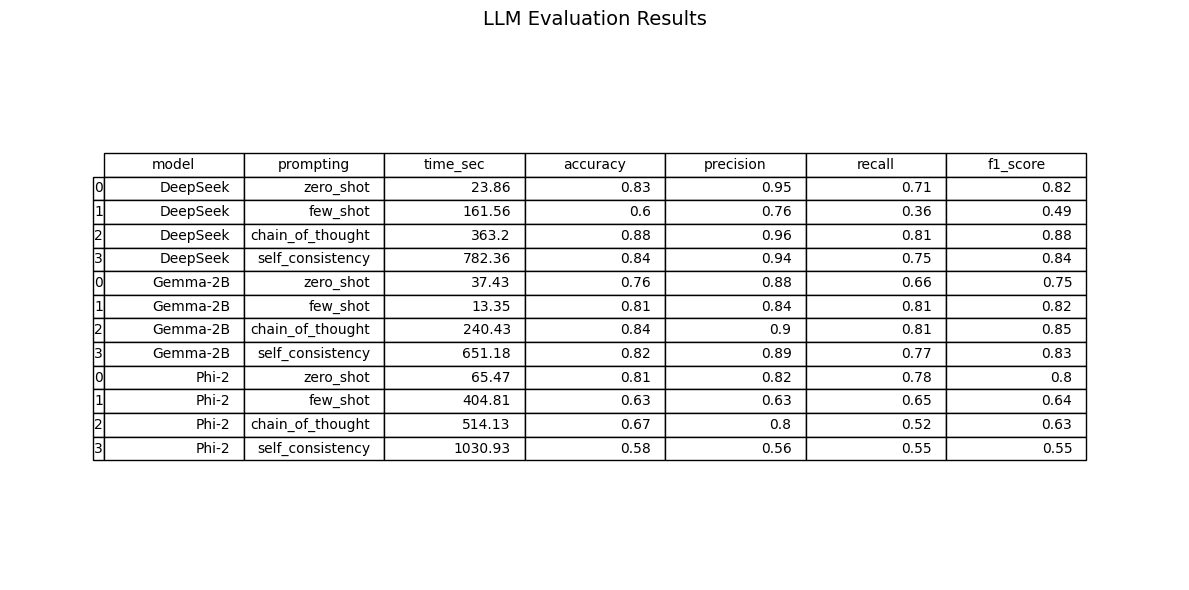

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# 🔄 Load and sort
results_df = pd.concat([
    pd.read_csv("gemma_2b_results.csv"),
    pd.read_csv("deepseek_results.csv"),
    pd.read_csv("phi_2_results.csv")
])

results_df = results_df.sort_values(by=["model"])

# ✅ Save to Excel
results_df.to_excel("llm_comparison_results.xlsx", index=False)
print("📁 Results saved to: llm_comparison_results.xlsx")

# 🎨 Plot as table and save as image
fig, ax = plt.subplots(figsize=(12, len(results_df) * 0.5))  # Adjust height for rows
ax.axis('off')
tbl = table(ax, results_df.round(2), loc='center', colWidths=[0.1] * len(results_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.title("LLM Evaluation Results", fontsize=14)
plt.tight_layout()
plt.savefig("llm_comparison_table.png")
plt.show()

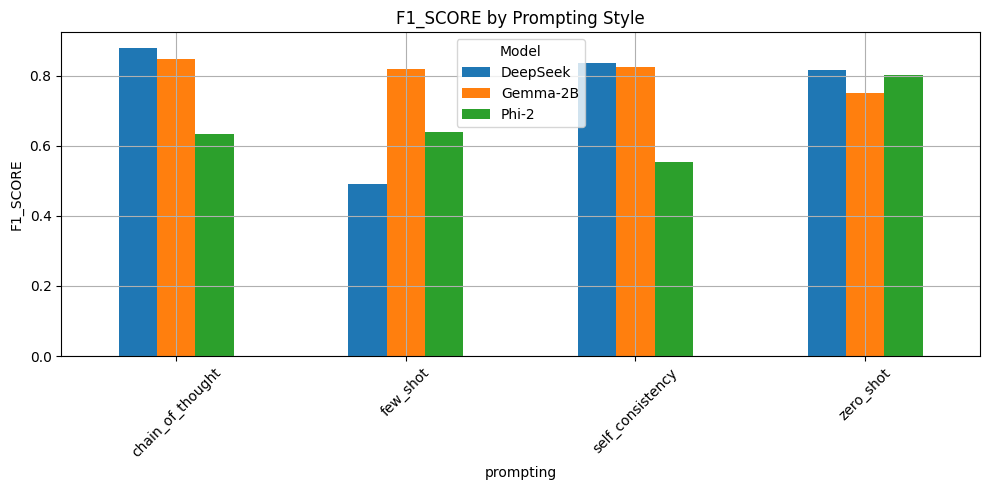

✅ Saved plot: f1_score_by_prompting_style.png


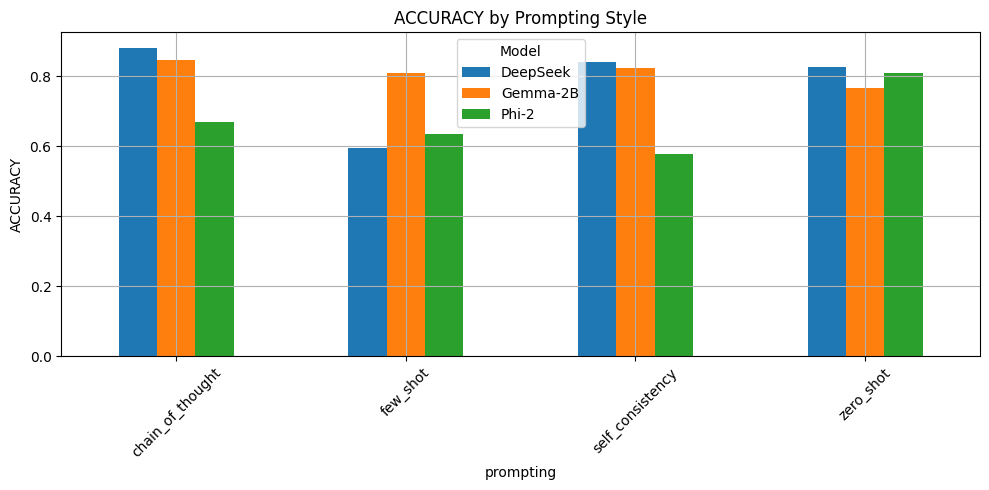

✅ Saved plot: accuracy_by_prompting_style.png


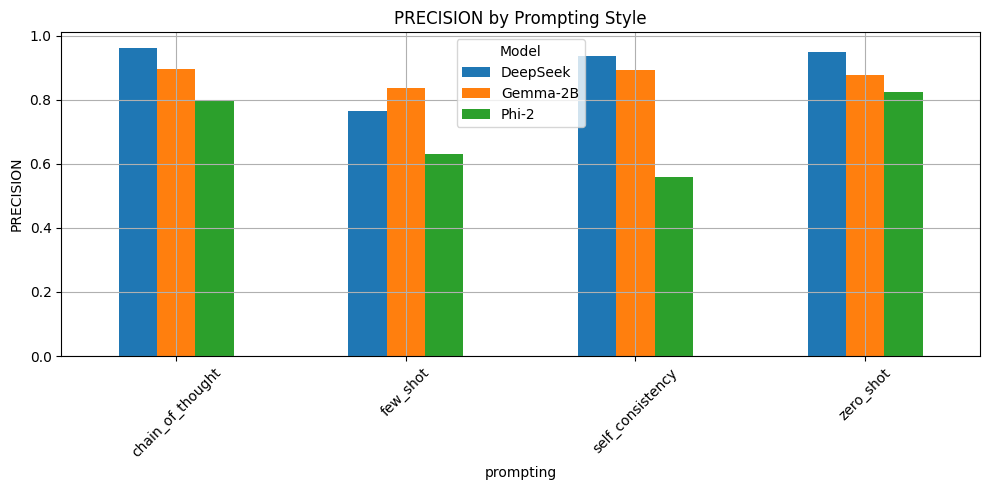

✅ Saved plot: precision_by_prompting_style.png


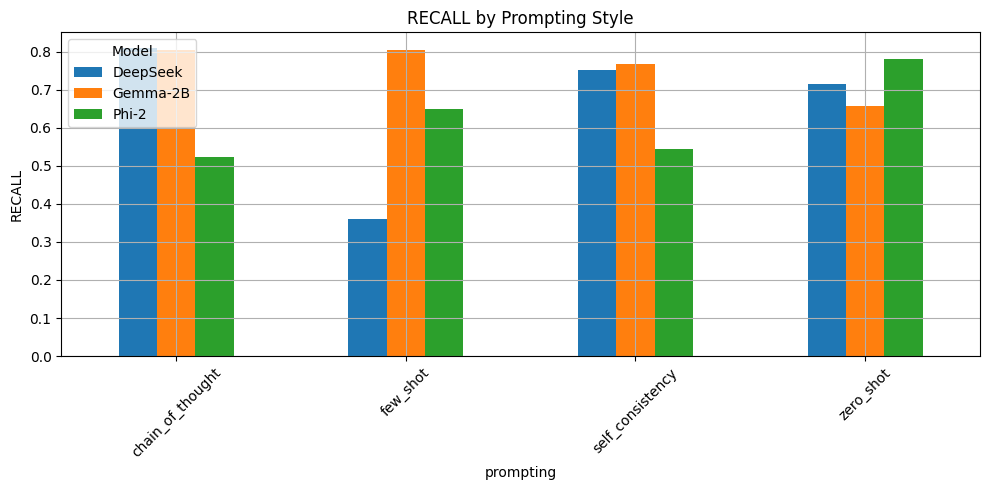

✅ Saved plot: recall_by_prompting_style.png


In [ ]:
import matplotlib.pyplot as plt

# Plot and save each metric as a PNG file
for metric in ["f1_score", "accuracy", "precision", "recall"]:
    pivot = results_df.pivot(index="prompting", columns="model", values=metric)

    ax = pivot.plot(kind="bar", figsize=(10, 5), title=f"{metric.upper()} by Prompting Style")
    plt.ylabel(metric.upper())
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Model")
    plt.tight_layout()

    # ✅ Save as PNG file
    filename = f"{metric}_by_prompting_style.png"
    plt.savefig(filename)

    # ✅ Show in notebook
    plt.show()

    print(f"✅ Saved plot: {filename}")